In [4]:
from pathlib import Path
import geopandas as gpd

file_path = Path("/home/vito/millig/projects/worldcereal/COP4GEOGLAM/kenya")
LR_file = list(file_path.glob("*LR*"))[0]
SR_file = list(file_path.glob("*SR*"))[0]
LR = gpd.read_parquet(LR_file)
SR = gpd.read_parquet(SR_file)

In [7]:
LR['extract']

0        0
1        0
2        0
3        0
4        0
        ..
25067    0
25068    1
25069    1
25070    1
25071    1
Name: extract, Length: 25072, dtype: int64

In [8]:
LR.columns

Index(['feature_index', 'sample_id', 'ref_id', 'timestamp', 'S2-L2A-B02',
       'S2-L2A-B03', 'S2-L2A-B04', 'S2-L2A-B05', 'S2-L2A-B06', 'S2-L2A-B07',
       'S2-L2A-B08', 'S2-L2A-B11', 'S2-L2A-B12', 'S1-SIGMA0-VH',
       'S1-SIGMA0-VV', 'slope', 'elevation', 'AGERA5-PRECIP', 'AGERA5-TMEAN',
       'lon', 'lat', 'geometry', 'tile', 'h3_l3_cell', 'start_date',
       'end_date', 'year', 'valid_time', 'ewoc_code', 'irrigation_status',
       'quality_score_lc', 'quality_score_ct', 'extract'],
      dtype='object')

In [13]:
import pandas as pd

ARTIFACTORY_BASE_URL = (
    "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/"
)
CROP_LEGEND_URL = ARTIFACTORY_BASE_URL + "legend/WorldCereal_LC_CT_legend_latest.csv"
legend = pd.read_csv(CROP_LEGEND_URL, header=0, sep=";")
legend["ewoc_code"] = legend["ewoc_code"].str.replace("-", "").astype(int)
legend = legend.ffill(axis=1)

LR["label_full"] = LR["ewoc_code"].map(
    legend.set_index("ewoc_code")["label_full"]
)
SR["label_full"] = SR["ewoc_code"].map(legend.set_index("ewoc_code")["label_full"])

In [12]:
LR["label_full"].unique()

array(['maize', 'cropland_unspecified', 'sugar_cane', 'sunflower',
       'leafy_stem_vegetables', 'grass_fodder_crops',
       'unspecified_millet', 'unspecified_sorghum', 'tea', 'cassava',
       'beans', 'pineapples', 'groundnuts', 'bananas_plantains',
       'unspecified_wheat', 'tomato', 'potatoes', 'sweet_potatoes',
       'non_cropland_herbaceous', 'trees_mixed', 'shrubland',
       'temporary_crops', 'built_up', 'vegetables_fruits', 'coffee',
       'onion_shallot', 'root_vegetables', 'cow_peas', 'carrots_daucus',
       'cabbage'], dtype=object)

In [17]:
import json 

CLASS_MAPPINGS = json.load(
    open(
        "/home/vito/millig/gio/worldcereal-cop4geoglam/src/worldcereal_cop4geoglam/data/class_mappings.json"
    )
)
ewoc_to_label = pd.concat(
    [LR[["ewoc_code", "label_full"]], SR[["ewoc_code", "label_full"]]]
).drop_duplicates()
croptype_ewoco_mapping = dict(
    zip(ewoc_to_label["ewoc_code"], ewoc_to_label["label_full"])
)

# Add to CLASS_MAPPINGS
CLASS_MAPPINGS["CROPTYPE_EWOCO"] = croptype_ewoco_mapping

In [21]:
# Reverse CROPTYPE to map label to code
label_to_croptype_code = {v: k for k, v in CLASS_MAPPINGS["CROPTYPE"].items()}

# Map ewoc_code (CROPTYPE_EWOCO keys) to croptype_code (CROPTYPE keys) via label_full
ewoco_to_croptype = {}
for ewoco, label in CLASS_MAPPINGS["CROPTYPE_EWOCO"].items():
    croptype_code = label_to_croptype_code.get(label)
    if croptype_code is not None:
        ewoco_to_croptype[ewoco] = croptype_code

# Add to CLASS_MAPPINGS
CLASS_MAPPINGS["EWOCO_TO_CROPTYPE"] = ewoco_to_croptype

CLASS_MAPPINGS["EWOCO_TO_CROPTYPE"]

{1101060000: '18', 1105010010: '6', 1106000050: '16'}

In [14]:
from sklearn.cluster import DBSCAN
import numpy as np

def cluster_points(df, distance=1, min_samples=10):
    # Ensure the geometry is in EPSG:4326
    if df.crs != 'EPSG:4326':
        df = df.to_crs('EPSG:4326')

    # Extract coordinates (assuming LR is in EPSG:4326)
    coords = np.vstack([df.geometry.y, df.geometry.x]).T
    coords_rad = np.radians(coords)
    # To increase the distance, increase the value of eps (in radians).
    # For example, for 2 km: eps = 2/6371
    # You can pass a different eps value when calling cluster_points, e.g. cluster_points(df, eps=2/6371)
    # DBSCAN with haversine metric (eps in radians, e.g. ~1km: 1/6371)
    db = DBSCAN(eps=distance/6371, min_samples=min_samples, metric='haversine').fit(coords_rad)
    df[f'{distance}km_patch_id'] = db.labels_
    return df

In [15]:
distance = 1  # distance in km
LR = cluster_points(LR, distance)
SR = cluster_points(SR, distance)

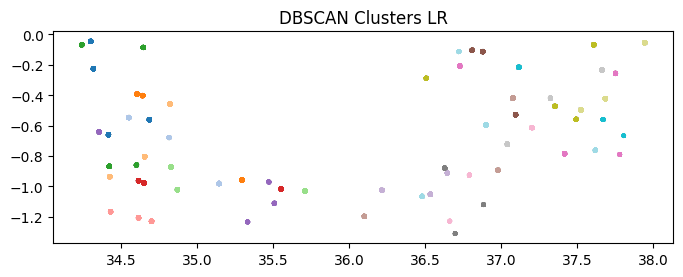

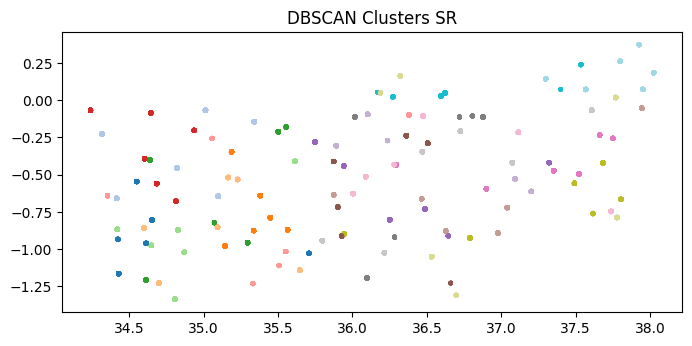

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 20))
LR.plot(column=f'{distance}km_patch_id', categorical=True, ax=ax, markersize=5, cmap='tab20')
ax.set_title("DBSCAN Clusters LR")

plt.show()

fig, ax = plt.subplots(figsize=(8, 20))
SR.plot(column=f'{distance}km_patch_id', categorical=True, ax=ax, markersize=5, cmap='tab20')
ax.set_title("DBSCAN Clusters SR")

plt.show()

In [18]:
SR.to_parquet(file_path / f"SR_{distance}km_clusters.geoparquet")
LR.to_parquet(file_path / f"LR_{distance}km_clusters.geoparquet")

In [ ]:
from pathlib import Path
from worldcereal_cop4geoglam.finetuning_utils import train_test_val_split, load_dataset


distance = 1  # distance in km
file_path = Path("/home/vito/millig/projects/worldcereal/COP4GEOGLAM/kenya")

parquet_files = file_path / f"SR_{distance}km_clusters.geoparquet"

if isinstance(parquet_files, (str, Path)):
    # If a single file is provided, convert it to a list
    parquet_files = [parquet_files]

if debug:
    # select 1st file in debug mode
    parquet_files = parquet_files[:1]
    logger.warning("Debug mode is enabled.")

df = None
for f in parquet_files:
    logger.info(f"Processing {f}")
    _data = pd.read_parquet(f, engine="fastparquet")
    _data = _data[_data["sample_id"].notnull()]
    _data["ewoc_code"] = _data["ewoc_code"].astype(int)

    for tcol in ["valid_time", "start_time", "end_time", "timestamp"]:
        if tcol in _data.columns:
            _data[tcol] = pd.to_datetime(_data[tcol], utc=True)
            _data[tcol] = _data[tcol].dt.tz_localize(None)

    _data_pivot = process_parquet(_data, freq=timestep_freq)
    _data_pivot.reset_index(inplace=True)
    df = _data_pivot if df is None else pd.concat([df, _data_pivot])

df = map_classes(df, finetune_classes, class_mappings=CLASS_MAPPINGS)

load_dataset(
    file_path / f"SR_{distance}km_clusters.geoparquet",
    timestep_freq = "month",
    finetune_classes = "CROPLAND",
)

2025-05-28 15:12:30 | INFO | Processing /home/vito/millig/projects/worldcereal/COP4GEOGLAM/kenya/SR_1km_clusters.geoparquet
2025-05-28 15:12:31 | INFO | Expected observations frequency: month; Median observed distance between observations: [31] days
2025-05-28 15:12:31 | WARNING | The following features are missing and are filled with NODATAVALUE: ['OPTICAL-B8A']
2025-05-28 15:12:31 | INFO | All samples have the expected number of observations.
2025-05-28 15:12:31 | WARNING | Some classes are missing in the mapping dictionary and thus will be removed: {'1201020020', '1201020010', '1107000020', '1106000050', '2000000000', '6000000000', '1202000000', '1101060000', '1103040000', '1105010050', '1201020060', '1202000010', '1109000500', '1101010000', '1201020040', '1202000020', '1103110070', '1103010010', '1103090000', '3000000000', '1103090040', '1103020040', '1105010010', '4300000000', '1201020000', '1107000010', '1111000000', '1205000000', '1103010020', '1111010100', '1200000000', '110700

,sample_id,DEM-slo-20m,end_date,irrigation_status,geometry,quality_score_lc,DEM-alt-20m,start_date,h3_l3_cell,1km_patch_id,...,METEO-precipitation_flux-ts10-100m,METEO-precipitation_flux-ts11-100m,METEO-precipitation_flux-ts12-100m,METEO-precipitation_flux-ts13-100m,METEO-precipitation_flux-ts14-100m,METEO-precipitation_flux-ts15-100m,METEO-precipitation_flux-ts16-100m,valid_date,finetune_class,balancing_class
